In [1]:
import glob # For getting file names
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
# import torch

from collections import Counter
# from gap_statistic import OptimalK
from scipy import stats, cluster
from sklearn.cluster import KMeans
# from yellowbrick.cluster import KElbowVisualizer

from utils.clustering_utils import *
from utils.conformal_utils import *

%load_ext autoreload
%autoreload 2

In [2]:
def generate_n_clustering_list(rarest_class_ct):
    '''
    Generate candidate n_clustering values 
    '''
    n_clustering_list = (np.array([.3, .5, .7, .9]) * rarest_class_ct).astype(np.int32)
    
    return n_clustering_list

def generate_num_clusters_list(num_classes):
    '''
    Generate candidate num_clusters values 
    '''
    # List of possible numbers of clusters (1-10, then grid of 5 points through 10% of num_classes)
    grid1 = np.arange(1, 11, dtype=int)
    grid2 = np.linspace(10, np.ceil(.1 * num_classes), 5, dtype=int) # Removed a +1 here, so might want to reun
    num_clusters_list = np.unique(np.concatenate((grid1, grid2)))
    
    return num_clusters_list
    

def compute_metrics_matrix(totalcal_scores_all, totalcal_labels,
                        alpha,
                        val_scores_all, val_labels, save_to=None,
                        n_clustering_list=None, num_clusters_list=None):
    '''
    save_to: file path to save metrics matix to
    '''
    
    num_classes = totalcal_scores_all.shape[1]
    
    if n_clustering_list is None:
        rarest_class_ct = Counter(totalcal_labels).most_common()[-1][1]
        n_clustering_list = generate_n_clustering_list(rarest_class_ct)
        
    if num_clusters_list is None:
        num_clusters_list = generate_num_clusters_list(num_classes)
        
        
    print('n_clustering_list:', n_clustering_list)
    print('num_clusters_list:', num_clusters_list)
        
    results = {} # For storing coverage and set size metrics
    
    for n_clustering in n_clustering_list:
        results[f'n_clustering={n_clustering}'] = {}
            
        for num_clusters in num_clusters_list: 
            results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}'] = {}
            
            qhats, preds, coverage_metrics, set_size_metrics = clustered_conformal(totalcal_scores_all, totalcal_labels,
                                                                alpha,
                                                                n_clustering, num_clusters,
                                                                val_scores_all=val_scores_all, val_labels=val_labels)
    
            results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['coverage_metrics'] = coverage_metrics
            results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['set_size_metrics'] = set_size_metrics
    
    if save_to is not None:
        with open(save_to,'wb') as f:
            pickle.dump(results, f)
            print(f'Saved metrics matrix to {save_to}')
    
    return results, n_clustering_list, num_clusters_list
    
def compute_N_metrics_matrices(scores_all, labels, n_totalcal,
                                alpha, save_folder,
                                seeds=[0,1,2,3,4],
                                n_clustering_list=None, num_clusters_list=None):
    '''
    Computes N different metrics matrices, each for a different calibration/validation
    split. N=len(seeds)
    
    Inputs:
        -seeds: list of ints used to seed the random data splitting
    '''
    os.makedirs(save_folder, exist_ok=True)

    for seed in seeds:
        totalcal_scores_all, totalcal_labels, val_scores_all, val_labels = split_X_and_y(scores_all, labels, n_totalcal, num_classes=num_classes, seed=seed)
        
        print(f'Computing metrics matrix for seed={seed}...')
        save_to = os.path.join(save_folder, f'seed={seed}_allmetrics.pkl')
        compute_metrics_matrix(totalcal_scores_all, totalcal_labels,
                                            alpha,
                                            val_scores_all, val_labels, save_to=save_to,
                                            n_clustering_list=None, num_clusters_list=None)
    
    
def visualize_heatmaps(results, n_clustering_list, num_clusters_list, n_totalcal):
    '''
    Visualizes metric matrix using metrics from a single random seed. 
    
    Input:
        - results: 
            metrics matrix, as produced by compute_metrics_matrix(), OR
            list of metrics matrices
    '''
    
    cov_arr = [[results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['coverage_metrics']['mean_class_cov_gap']
                       for n_clustering in n_clustering_list] for num_clusters in num_clusters_list]
    cov_arr = np.array(cov_arr) * 100

    avg_set_size_arr = [[results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['set_size_metrics']['mean']
                       for n_clustering in n_clustering_list] for num_clusters in num_clusters_list]
    # Can also make plots for set size quantiles

    title_prefix = f'[{score_function}]'

    ax = sns.heatmap(cov_arr, annot=True,
                    cmap=sns.color_palette("viridis_r", as_cmap=True))
    ax.set(title=f'{title_prefix} Average class coverage gap (%)',
           xlabel=f"# of points used for clustering (out of {n_totalcal})", 
           ylabel="# of clusters")
    ax.set_xticklabels(n_clustering_list)
    ax.set_yticklabels(num_clusters_list)
    plt.show()

    ax = sns.heatmap(avg_set_size_arr, annot=True,
                     cmap=sns.color_palette("magma_r", as_cmap=True),
                     vmax=40)
    ax.set(title=f'{title_prefix} Average set size',
           xlabel=f"# of points used for clustering (out of {n_totalcal})", 
           ylabel="# of clusters")
    ax.set_xticklabels(n_clustering_list)
    ax.set_yticklabels(num_clusters_list)
    plt.show()
    
def visualize_heatmaps_with_SE(folder, n_clustering_list, num_clusters_list, n_totalcal):
    '''
    Visualizes metric matrix using metrics from multiple random seeds. Computes mean and
    standard error across random seeds.
    
    Input:
        - folder: path to folder containing saved metric matrices, as produced by 
        compute_metrics_matrix() All files in the folder that match "*.pkl" will be used. 

    '''
    
    file_names = sorted(glob.glob(os.path.join(folder, '*.pkl')))
#     print('Files found:', file_names)
    
    cov_arr_all = []
    avg_set_size_arr_all = []
        
    for pth in file_names:
        with open(pth, 'rb') as f:
            results = pickle.load(f)

        cov_arr = [[results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['coverage_metrics']['mean_class_cov_gap']
                           for n_clustering in n_clustering_list] for num_clusters in num_clusters_list]
        cov_arr = np.array(cov_arr) * 100

        avg_set_size_arr = [[results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['set_size_metrics']['mean']
                       for n_clustering in n_clustering_list] for num_clusters in num_clusters_list]
    
        cov_arr_all.append(cov_arr)
        avg_set_size_arr_all.append(avg_set_size_arr)
    
    cov_arr_all = np.array(cov_arr_all)
    avg_set_size_arr_all = np.array(avg_set_size_arr_all)
    
    title_prefix = f'[{score_function}]'
    
    cov_mean = np.mean(cov_arr_all, axis=0)
    cov_se = np.std(cov_arr_all, axis=0, ddof=1) # UPDATED
    plt_labels = np.array([[f'{cov_mean[i,j]:.2f} ({cov_se[i,j]:.2f})' for j in range(cov_mean.shape[1])] for i in range(cov_mean.shape[0])])
    ax = sns.heatmap(cov_mean, annot=plt_labels, fmt = '',
                    vmin=1.8, vmax=7, # OPTIONAL: adjust these for consistency between plots
                    cmap=sns.color_palette("viridis_r", as_cmap=True))
    ax.set(title=f'{title_prefix} Class coverage gap as % (SE in parentheses)',
           xlabel=f"# of points used for clustering (out of {n_totalcal})", 
           ylabel="# of clusters")
    ax.set_xticklabels(n_clustering_list)
    ax.set_yticklabels(num_clusters_list)
    plt.show()

    # Plot average set size
    size_mean = np.mean(avg_set_size_arr_all, axis=0)
    size_se = np.std(avg_set_size_arr_all, axis=0, ddof=1) # UPDATED
    plt_labels = np.array([[f'{size_mean[i,j]:.2f} ({size_se[i,j]:.2f})' for j in range(size_mean.shape[1])] for i in range(size_mean.shape[0])])
    ax = sns.heatmap(size_mean, annot=plt_labels, fmt = '',
                    vmin=37, vmax=60, # OPTIONAL: adjust these for consistency between plots
                     cmap=sns.color_palette("magma_r", as_cmap=True))
    ax.set(title=f'{title_prefix} Average set size (SE in parentheses)',
           xlabel=f"# of points used for clustering (out of {n_totalcal})", 
           ylabel="# of clusters")
    ax.set_xticklabels(n_clustering_list)
    ax.set_yticklabels(num_clusters_list)
    plt.show()

# Run

In [3]:
alpha = .1
n_totalcal = 30 # Total number of calibration points (= # clustering examples + # conformal calibration examples)
seeds = [0,1,2,3,4]

# Enron - BERT (n_train=500)
softmax_path = "../class-conditional-conformal-datasets/notebooks/.cache/email_softmax_bert_ntrain=500.npy"
labels_path = "../class-conditional-conformal-datasets/notebooks/.cache/email_labels_bert_ntrain=500.npy"
save_folder = f'.cache/enron_n={n_totalcal}'

# # ImageNet
# softmax_path = '/home/tding/data/finetuned_imagenet/imagenet_train_subset_softmax.npy'
# labels_path = '/home/tding/data/finetuned_imagenet/imagenet_train_subset_labels.npy'
# save_folder = f'.cache/imagenet_n={n_totalcal}'


In [4]:
# Load data
print('Loading softmax scores and labels...')

softmax_scores = np.load(softmax_path)
labels = np.load(labels_path)

num_classes = labels.max() + 1

Loading softmax scores and labels...


In [5]:
print(f'n_totalcal={n_totalcal}')
for score_function in ['softmax', 'APS']:
    
    print(f'====== score_function={score_function} ======')
    
    print('Computing conformal score...')
    if score_function == 'softmax':
        scores_all = 1 - softmax_scores
    elif score_function == 'APS':
        scores_all = get_APS_scores_all(softmax_scores, randomize=True)
    elif score_function == 'RAPS': 
        
        # RAPS hyperparameters (currently using ImageNet defaults)
        lmbda = .01 
        kreg = 5
        
        scores_all = get_RAPS_scores_all(softmax_scores, lmbda, kreg, randomize=True)
    else:
        raise Exception('Undefined score function')

    curr_save_folder = os.path.join(save_folder, score_function)
    compute_N_metrics_matrices(scores_all, labels, n_totalcal,
                                    alpha, curr_save_folder,
                                    seeds=seeds,
                                    n_clustering_list=None, num_clusters_list=None)

n_totalcal=30
====== score_function=softmax ======
Computing conformal score...
Computing metrics matrix for seed=0...
n_clustering_list: [ 9 15 21 27]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11]
Cluster sizes: [109]
Cluster sizes: [98, 11]
Cluster sizes: [94, 13, 2]
Cluster sizes: [68, 30, 9, 2]
Cluster sizes: [68, 29, 8, 2, 2]
Cluster sizes: [64, 24, 11, 6, 2, 2]
Cluster sizes: [60, 24, 14, 7, 2, 1, 1]
Cluster sizes: [64, 22, 11, 5, 3, 2, 1, 1]
Cluster sizes: [64, 21, 12, 4, 2, 2, 2, 1, 1]
Cluster sizes: [36, 28, 20, 12, 4, 3, 2, 2, 1, 1]
Cluster sizes: [42, 26, 18, 10, 3, 3, 3, 1, 1, 1, 1]
Cluster sizes: [109]
Cluster sizes: [98, 11]
Cluster sizes: [76, 26, 7]
Cluster sizes: [76, 26, 4, 3]
Cluster sizes: [69, 28, 7, 3, 2]
Cluster sizes: [69, 28, 7, 3, 1, 1]
Cluster sizes: [56, 21, 20, 7, 3, 1, 1]
Cluster sizes: [56, 22, 19, 6, 3, 1, 1, 1]
Cluster sizes: [56, 21, 18, 5, 4, 2, 1, 1, 1]
Cluster sizes: [56, 22, 19, 4, 2, 2, 1, 1, 1, 1]
Cluster sizes: [56, 21, 18, 4, 2, 2, 2, 1

Cluster sizes: [58, 28, 12, 5, 2, 1, 1, 1, 1]
Cluster sizes: [58, 28, 12, 5, 1, 1, 1, 1, 1, 1]
Cluster sizes: [58, 27, 7, 6, 5, 1, 1, 1, 1, 1, 1]
Saved metrics matrix to .cache/enron_n=30/softmax/seed=1_allmetrics.pkl
Computing metrics matrix for seed=2...
n_clustering_list: [ 9 15 21 27]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11]
Cluster sizes: [109]
Cluster sizes: [98, 11]
Cluster sizes: [97, 10, 2]
Cluster sizes: [75, 23, 9, 2]
Cluster sizes: [75, 23, 9, 1, 1]
Cluster sizes: [75, 23, 6, 3, 1, 1]
Cluster sizes: [57, 24, 17, 8, 1, 1, 1]
Cluster sizes: [57, 24, 17, 6, 2, 1, 1, 1]
Cluster sizes: [57, 24, 17, 4, 3, 1, 1, 1, 1]
Cluster sizes: [57, 21, 11, 9, 6, 1, 1, 1, 1, 1]
Cluster sizes: [57, 23, 17, 4, 2, 1, 1, 1, 1, 1, 1]
Cluster sizes: [109]
Cluster sizes: [100, 9]
Cluster sizes: [96, 12, 1]
Cluster sizes: [95, 10, 3, 1]
Cluster sizes: [73, 23, 9, 3, 1]
Cluster sizes: [72, 23, 9, 2, 2, 1]
Cluster sizes: [72, 22, 6, 5, 2, 1, 1]
Cluster sizes: [72, 22, 6, 4, 2, 1, 1, 1]
Clu

Saved metrics matrix to .cache/enron_n=30/softmax/seed=3_allmetrics.pkl
Computing metrics matrix for seed=4...
n_clustering_list: [ 9 15 21 27]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11]
Cluster sizes: [109]
Cluster sizes: [94, 15]
Cluster sizes: [84, 17, 8]
Cluster sizes: [84, 17, 6, 2]
Cluster sizes: [74, 17, 10, 6, 2]
Cluster sizes: [74, 18, 7, 5, 4, 1]
Cluster sizes: [74, 18, 7, 5, 2, 2, 1]
Cluster sizes: [59, 24, 9, 7, 5, 2, 2, 1]
Cluster sizes: [59, 24, 9, 7, 3, 2, 2, 2, 1]
Cluster sizes: [57, 26, 9, 4, 4, 2, 2, 2, 2, 1]
Cluster sizes: [45, 26, 13, 8, 5, 3, 2, 2, 2, 2, 1]
Cluster sizes: [109]
Cluster sizes: [100, 9]
Cluster sizes: [84, 18, 7]
Cluster sizes: [84, 18, 5, 2]
Cluster sizes: [72, 20, 10, 5, 2]
Cluster sizes: [72, 20, 10, 5, 1, 1]
Cluster sizes: [72, 20, 10, 4, 1, 1, 1]
Cluster sizes: [61, 25, 13, 3, 3, 2, 1, 1]
Cluster sizes: [38, 31, 15, 10, 8, 3, 2, 1, 1]
Cluster sizes: [58, 26, 10, 6, 3, 2, 1, 1, 1, 1]
Cluster sizes: [38, 31, 15, 8, 8, 3, 2, 1, 1, 1, 1]


Cluster sizes: [19, 17, 16, 15, 12, 12, 11, 7]
Cluster sizes: [22, 17, 14, 12, 12, 11, 10, 7, 4]
Cluster sizes: [19, 17, 15, 14, 12, 10, 9, 7, 4, 2]
Cluster sizes: [21, 18, 12, 11, 11, 8, 8, 7, 7, 4, 2]
Cluster sizes: [109]
Cluster sizes: [60, 49]
Cluster sizes: [45, 39, 25]
Cluster sizes: [37, 36, 25, 11]
Cluster sizes: [32, 28, 24, 14, 11]
Cluster sizes: [28, 28, 18, 14, 11, 10]
Cluster sizes: [24, 24, 18, 14, 11, 10, 8]
Cluster sizes: [24, 21, 18, 15, 10, 8, 8, 5]
Cluster sizes: [23, 19, 14, 12, 11, 10, 9, 6, 5]
Cluster sizes: [21, 14, 12, 12, 11, 10, 9, 9, 6, 5]
Cluster sizes: [21, 17, 13, 11, 10, 8, 7, 7, 7, 5, 3]
Saved metrics matrix to .cache/enron_n=30/APS/seed=1_allmetrics.pkl
Computing metrics matrix for seed=2...
n_clustering_list: [ 9 15 21 27]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11]
Cluster sizes: [109]
Cluster sizes: [60, 49]
Cluster sizes: [45, 40, 24]
Cluster sizes: [38, 25, 23, 23]
Cluster sizes: [28, 23, 21, 19, 18]
Cluster sizes: [22, 21, 21, 21, 13, 11

folder: .cache/enron_n=30/softmax


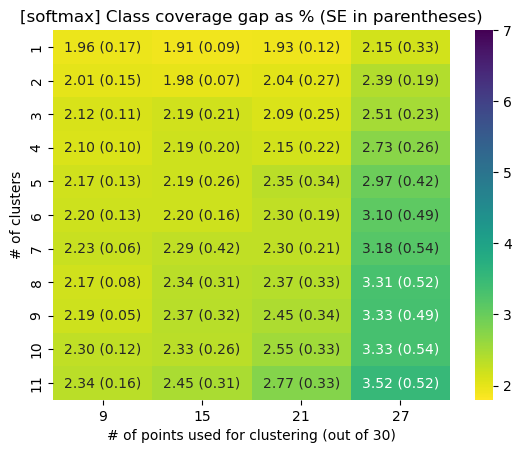

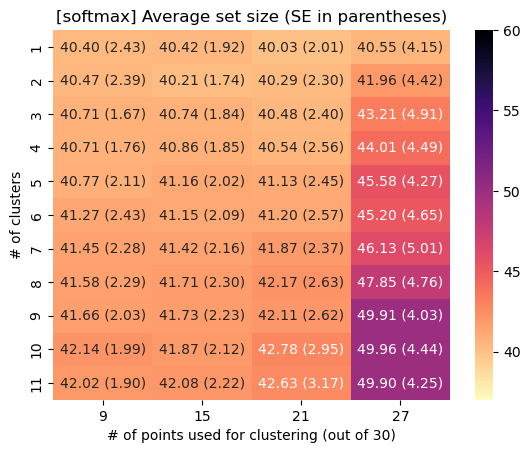

folder: .cache/enron_n=30/APS


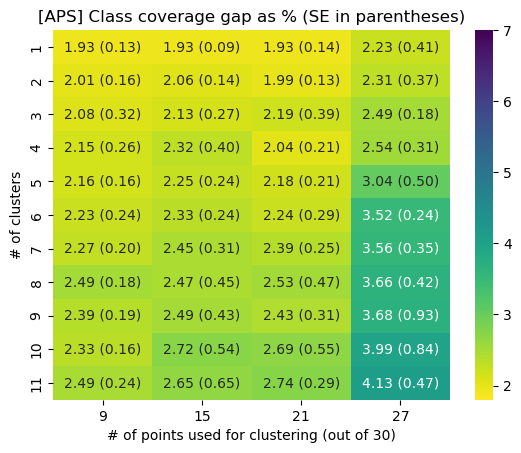

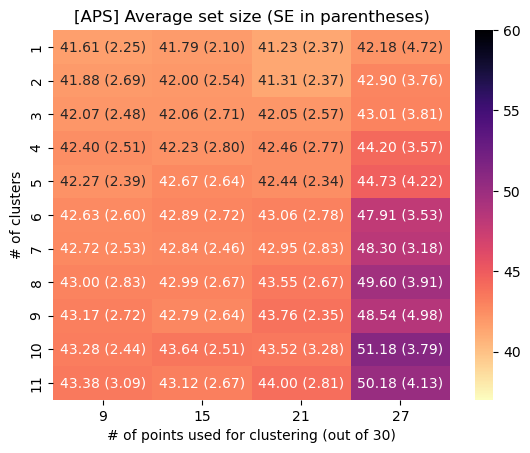

In [6]:
# Load precomputed metrics and make heatmaps
n_clustering_list = generate_n_clustering_list(n_totalcal)
num_clusters_list = generate_num_clusters_list(num_classes)
for score_function in ['softmax', 'APS']:
    
    folder = os.path.join(save_folder, score_function)
    print('folder:', folder)
    visualize_heatmaps_with_SE(folder, n_clustering_list, num_clusters_list, n_totalcal)
    

In [7]:
# TODO: implement cluster-conditional coverage computation (will have to rerun everything)